#GDrive Implementation

# Deep Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "content/train"
test_dir = "content/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

In [3]:

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

In [4]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "grayscale",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


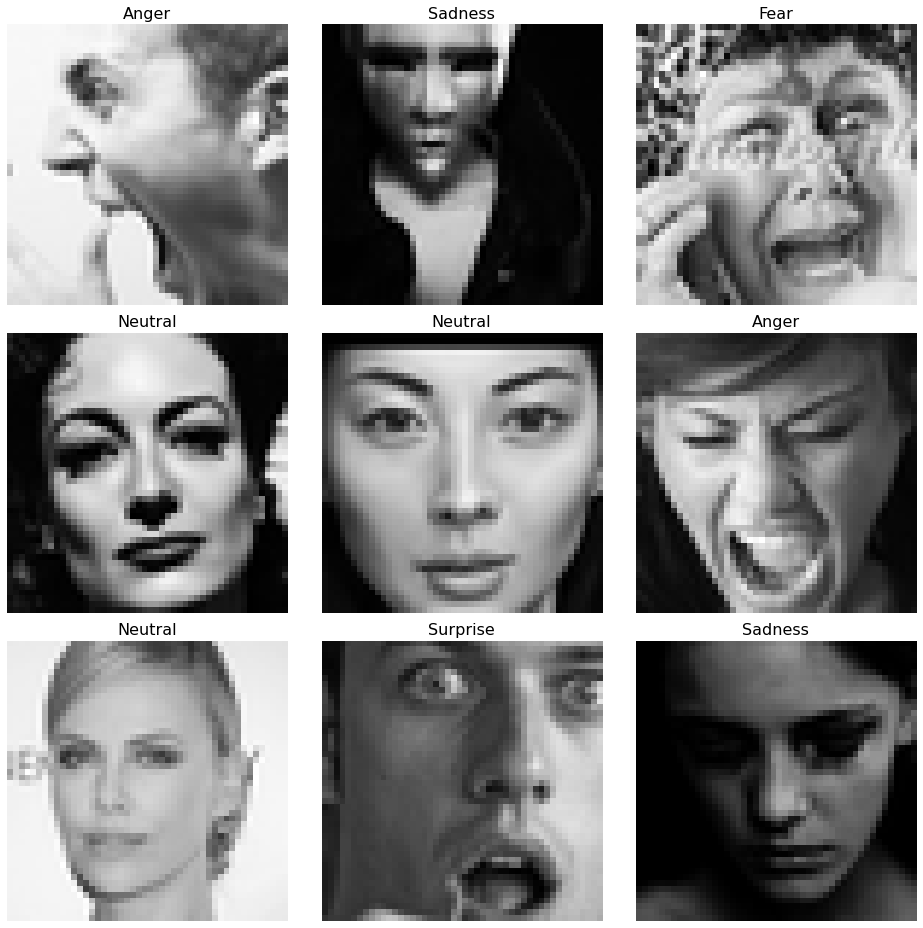

In [5]:
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

In [6]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

#Building Model phase

In [7]:
#Initializing VGG16
model = tf.keras.models.Sequential()

In [8]:
################ 1stLayer ################
#Convolution
model.add(ZeroPadding2D((1,1), input_shape=(48,48,1)))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
#Pooling
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
model.add(tf.keras.layers.Dropout(0.25))

In [9]:
################# 2ndLayer ################
#Convolution
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
#Pooling
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
model.add(tf.keras.layers.Dropout(0.25))

In [10]:
################ 3rdLayer ################
#Convolution
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
#Pooling
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
model.add(tf.keras.layers.Dropout(0.25))

In [11]:
################ 4thLayer ################
#Convolution
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
#Pooling
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
model.add(tf.keras.layers.Dropout(0.25))

In [12]:
################ 5thLayer ################
#Convolution
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
model.add(ZeroPadding2D((1,1)))
model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, activation = 'relu',input_shape = [48,48,1]))
#Pooling
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
model.add(tf.keras.layers.Dropout(0.25))

In [13]:
#Flattening
model.add(tf.keras.layers.Flatten())

In [14]:
#Full Connection

#Hidden Layers
model.add(tf.keras.layers.Dense(units = 128,activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

In [15]:
model.add(tf.keras.layers.Dense(units = 256, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

In [16]:
model.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

In [17]:
#Output Layer
model.add(tf.keras.layers.Dense(units = 7, activation = 'softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 50, 50, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 50, 50, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                        

# Training


In [19]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
359/359 [==============================] - 19s 44ms/step - loss: 2.1431 - accuracy: 0.1936 - val_loss: 1.8187 - val_accuracy: 0.2493
Epoch 2/30
359/359 [==============================] - 15s 42ms/step - loss: 1.9062 - accuracy: 0.2210 - val_loss: 1.8173 - val_accuracy: 0.2311
Epoch 3/30
359/359 [==============================] - 15s 42ms/step - loss: 1.8559 - accuracy: 0.2299 - val_loss: 1.8421 - val_accuracy: 0.2505
Epoch 4/30
359/359 [==============================] - 15s 42ms/step - loss: 1.8330 - accuracy: 0.2468 - val_loss: 1.7991 - val_accuracy: 0.2339
Epoch 5/30
359/359 [==============================] - 15s 42ms/step - loss: 1.8262 - accuracy: 0.2448 - val_loss: 3.6591 - val_accuracy: 0.1683
Epoch 6/30
359/359 [==============================] - 16s 44ms/step - loss: 1.7883 - accuracy: 0.2720 - val_loss: 1.7627 - val_accuracy: 0.2829
Epoch 7/30
359/359 [==============================] - 16s 45ms/step - loss: 1.7258 - accuracy: 0.3084 - val_loss: 1.7031 - val_accuracy:

#Training Plots

In [22]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [23]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

#Visualize Result

In [24]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 2s 21ms/step - loss: 1.1258 - accuracy: 0.5745


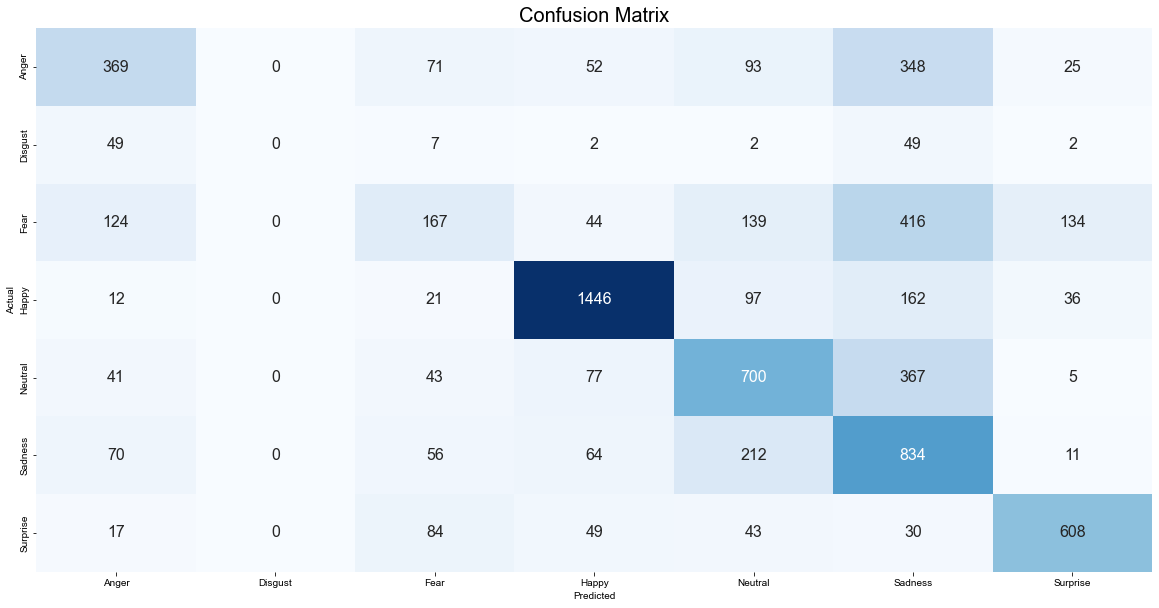

In [25]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

#Classification Report

In [26]:
print(classification_report(y_test, y_preds))


              precision    recall  f1-score   support

           0       0.54      0.39      0.45       958
           1       0.00      0.00      0.00       111
           2       0.37      0.16      0.23      1024
           3       0.83      0.82      0.82      1774
           4       0.54      0.57      0.56      1233
           5       0.38      0.67      0.48      1247
           6       0.74      0.73      0.74       831

    accuracy                           0.57      7178
   macro avg       0.49      0.48      0.47      7178
weighted avg       0.58      0.57      0.56      7178



#Multiclass AUC Curve


ROC AUC score: 0.8922289812066493


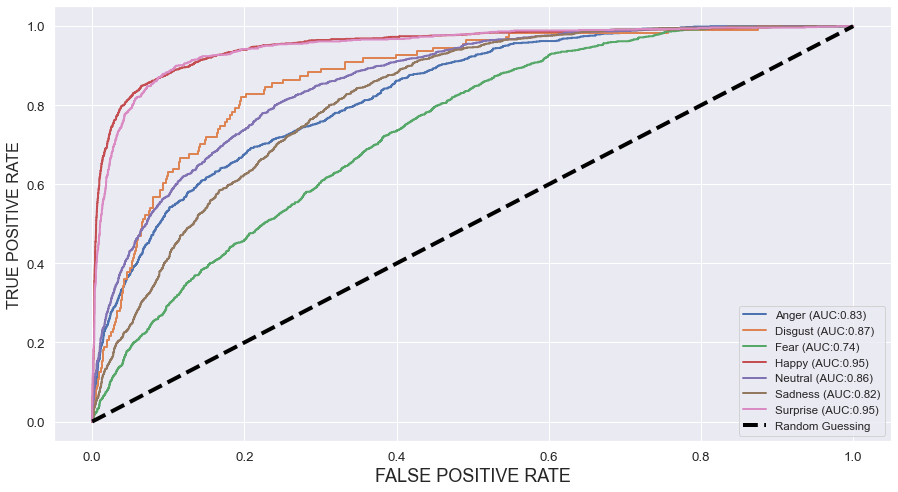

In [27]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [28]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8605979497296694


#Graph

NameError: name 'output' is not defined

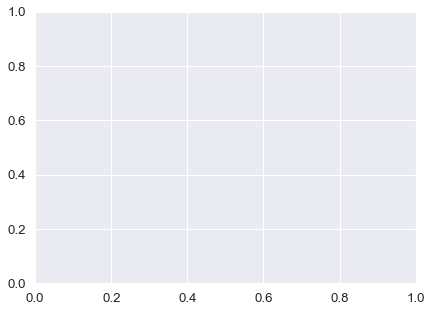

In [29]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(output.history['accuracy'], label='accuracy')
plt.plot(output.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Test accuracy'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(output.history['loss'], label='loss')
plt.plot(output.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train accurac','Test accuracy'], loc='upper right')

test_loss, test_acc = model.evaluate(test_set, verbose=2)